# Weather Station

while read line; do
    echo $line;
    zzz=$(( $RANDOM % 3 ))
    sleep 0.${zzz}
done < $1 | nc -lk $2


OKOK


In [8]:

from pyspark.streaming import StreamingContext
# The "1" here is the number of seconds between microbatches:
ssc = StreamingContext(sc, 0.5)

# Required to be able to do state updates:
ssc.checkpoint("checkpoint")
#ssc.checkpoint("file:///home/mchen81/Project3/spark-tmp")

In [9]:
# Updates our distribution
def update_temp(new_values, old_values):
    return sum(new_values) + (old_values or 0)

In [10]:
import geohash
import datetime

#  surface temperature, pressure, humidity, precipitation, visibility, and wind speed
def parseLine(line):    
    variables = line.split("\t")
    try:
        milliseconds = int(variables[0])
        dt = datetime.datetime.fromtimestamp(milliseconds/1000.0)
        lat = float(variables[1])
        lon = float(variables[2])
        pressure = float(variables[6])
        humidity = float(variables[8])
        temperature = float(variables[10]) - 273.15 #in celcius
        precipitation = float(variables[13])
        visibility = float(variables[15])
        # wind_speed = float(variables[17] == 'null' if 0 else variables[17])
        gh = geohash.encode(lat, lon)
        return (gh[0:3], dt.month, pressure, humidity, temperature, precipitation, visibility)

    except:
        return ('', 0)

In [11]:
# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far

def update_mean(newValues, existingAggregate):    
    (count, mean, M2) = (existingAggregate or (0, 0, 0))
    for newValue in newValues:
        count += 1
        delta = newValue - mean
        mean += delta / count
        delta2 = newValue - mean
        M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return [mean]

In [12]:
BOSTON = 'drt'
SD = '9mu'
SF = '9q8'
RICHMOND = '9q9'
LA = '9q5'
def check_location(gh):
    return  gh == BOSTON or \
            gh == SD or \
            gh == SF or \
            gh == RICHMOND or \
            gh == LA    

def finalize_rdd(rdd):
    data = rdd.collect()
    for ele in data:
        print((ele[0],finalize(ele[1])))

In [13]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython import display

# Plots the distribution. This executes on the driver!
def plot_distribution(rdd):
    display.clear_output(wait=True)
    df = pd.DataFrame(rdd, columns=['location', 'mean'])
    df.sort_values('location', ascending=True) \
        .plot(kind='bar', x='location', y='mean')
    display.display(plt.gcf())
    plt.close()


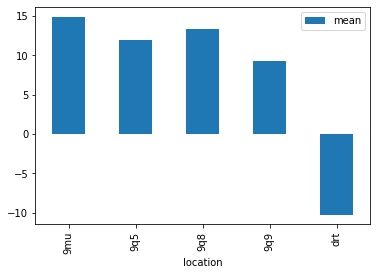

-------------------------------------------
Time: 2020-11-26 05:42:01.500000
-------------------------------------------
['drt', -10.246301056268472]
['9q8', 13.325438544739459]
['9q5', 12.020306167147]
['9mu', 14.900277028037426]
['9q9', 9.309414245917411]



ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [14]:
lines = ssc.socketTextStream("orion03", 12889)
weather_info = lines.map(lambda line: parseLine(line))
filtered_location = weather_info.filter(lambda t: check_location(t[0]))
location_pressure = filtered_location.map(lambda t: (t[0], t[4])) # geo-hash -> pressure
distrib = location_pressure.updateStateByKey(update_mean)
finalized = distrib.map(lambda dis: [dis[0]] + finalize(dis[1]))
finalized.foreachRDD(lambda rdd: plot_distribution(rdd.collect()))
finalized.pprint()
#finalized.foreachRDD(lambda rdd: rdd.foreach(ppp))
# display.display(plt.gcf())
ssc.start()
# ssc.awaitTermination()

In [8]:
ssc.stop(stopSparkContext=False)

-------------------------------------------
Time: 2020-11-26 05:36:34
-------------------------------------------

